In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import time
from gensim import corpora, models, similarities

In [2]:
path_to_data = "~/Documents/polytechnique/3A/nlp/link-prediction/data/"

In [3]:
nodes_header = ["id", "year", "title", "authors", "journal", "abstract"]
nodes = pd.read_csv(path_to_data+"node_information.csv", names=nodes_header)
nodes.set_index("id", inplace=True)

In [4]:
nodes.head()

,year,title,authors,journal,abstract
id,,,,,
1001,2000,compactification geometry and duality,Paul S. Aspinwall,NaN,these are notes based on lectures given at tas...
1002,2000,domain walls and massive gauged supergravity p...,"M. Cvetic, H. Lu, C.N. Pope",Class.Quant.Grav.,we point out that massive gauged supergravity ...
1003,2000,comment on metric fluctuations in brane worlds,"Y.S. Myung, Gungwon Kang",NaN,recently ivanov and volovich hep-th 9912242 cl...
1004,2000,moving mirrors and thermodynamic paradoxes,Adam D. Helfer,Phys.Rev.,quantum fields responding to moving mirrors ha...
1005,2000,bundles of chiral blocks and boundary conditio...,"J. Fuchs, C. Schweigert",NaN,proceedings of lie iii clausthal july 1999 var...


In [5]:
nodes.describe()

,year
count,27770.000000
mean,1998.009039
std,3.124684
min,1992.000000
25%,1995.000000
50%,1998.000000
75%,2001.000000
max,2003.000000


number of unique authors: 16691


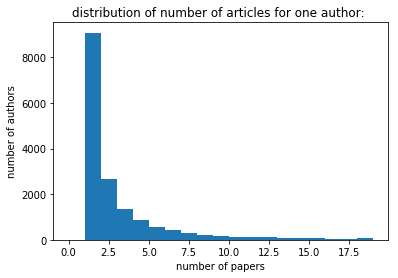

In [9]:
author_count = {}
for authors in nodes["authors"]:
    if pd.notnull(authors):
        e = authors.split(", ")
        for a in e:
            if e != "":
                if a not in author_count:
                    author_count[a] = 1
                else:
                    author_count[a] += 1

author_count[""] = 0
distrib = []
for v in author_count.values():
    distrib.append(v)
distrib = np.array(distrib)

print("number of unique authors: "+str(len(author_count)))

plt.title("distribution of number of articles for one author: ")
plt.xlabel("number of papers")
plt.ylabel("number of authors")
plt.hist(distrib, bins=range(0,20));

In [10]:
names = ["id1", "id2", "target"]
training = pd.read_csv(path_to_data+"training_set.txt", names=names, delimiter=" ")
training_set_size = 615512

In [11]:
training.describe()

,id1,id2,target
count,6.155120e+05,6.155120e+05,615512.000000
mean,5.317422e+06,6.798460e+06,0.544474
std,4.749198e+06,4.343138e+06,0.498019
min,1.001000e+03,1.001000e+03,0.000000
25%,1.112660e+05,2.080790e+05,0.000000
50%,9.310036e+06,9.505058e+06,1.000000
75%,9.708050e+06,9.709097e+06,1.000000
max,9.912293e+06,9.912293e+06,1.000000


In [12]:
training.head()

,id1,id2,target
0,9510123,9502114,1
1,9707075,9604178,1
2,9312155,9506142,0
3,9911255,302165,0
4,9701033,209076,0


In [13]:
training["my_index"] = training["id1"].astype(str) + "|" + training["id2"].astype(str)
training.set_index("my_index", inplace=True)
training.head()

,id1,id2,target
my_index,,,
9510123|9502114,9510123,9502114,1
9707075|9604178,9707075,9604178,1
9312155|9506142,9312155,9506142,0
9911255|302165,9911255,302165,0
9701033|209076,9701033,209076,0


In [14]:
def get_overlapping_words_abstract(id1, id2):
    abstract_1 = nodes.at[id1, "abstract"]
    abstract_2 = nodes.at[id2, "abstract"]
    abstract_1 = abstract_1.split(" ")
    abstract_2 = abstract_2.split(" ")
    ans = 0
    
    for e in abstract_1:
        if e in abstract_2:
            ans += 1
            
    return ans

In [15]:
my_training = training.copy()
my_training["overlapping_words_in_abstract"] = 0

i = 0.0

for index, row in my_training.iterrows():
    id1, id2 = row["id1"], row["id2"]
    row["overlapping_words_in_abstract"] = get_overlapping_words_abstract(id1, id2)
    i += 1
    if int(i) % 100000 == 0:
        print(str(100.0*i/training_set_size)[:4]+"% of the task done", flush=True)

my_training.head()

16.2% of the task done
32.4% of the task done
48.7% of the task done
64.9% of the task done
81.2% of the task done
97.4% of the task done


,id1,id2,target,overlapping_words_in_abstract
my_index,,,,
9510123|9502114,9510123,9502114,1,18
9707075|9604178,9707075,9604178,1,19
9312155|9506142,9312155,9506142,0,32
9911255|302165,9911255,302165,0,34
9701033|209076,9701033,209076,0,46


In [16]:
training = my_training
del my_training

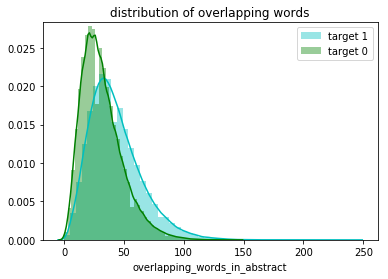

In [17]:
distrib_1 = training[training["target"] == 1]["overlapping_words_in_abstract"]
distrib_0 = training[training["target"] == 0]["overlapping_words_in_abstract"]
fig, ax = plt.subplots()
sns.distplot(distrib_1, ax=ax, color='c', label="target 1")
sns.distplot(distrib_0, ax=ax, color='g', label="target 0")
ax.set_title("distribution of overlapping words")
ax.legend();

In [18]:
abstracts = nodes["abstract"]
my_abstracts= [e.split(" ") for e in abstracts]
dictionary = corpora.Dictionary(my_abstracts)
i = 0
for (k, v) in dictionary.iteritems():
    i += 1
print("number of unique words in the vocabulary: "+str(i))

number of unique words in the vocabulary: 36392


In [21]:
my_training = training.copy()

tfidf = models.TfidfModel(dictionary=dictionary)


def get_tf_idf_encoding(index):
    abstract = nodes.at[index, "abstract"]
    abstract = abstract.split(" ")
    abstract = dictionary.doc2bow(abstract)
    ans = tfidf[[abstract]]
    return ans[0]

def my_norm(f):
    ans = 0.0
    
    for (k, v) in f:
        ans += v**2
    
    return np.sqrt(ans)
    
def cosine_distance(id1, id2):
    f1 = get_tf_idf_encoding(id1)
    f2 = get_tf_idf_encoding(id2)
    denom = my_norm(f1) * my_norm(f2)
    f1 = dict(f1)
    f2 = dict(f2)

    ans = 0.0
    
    for k, v in f1.items():
        if k in f2.keys():
            ans += v * f2[k]
    
    return ans/denom

my_training = training.copy()
my_training["cosine_distance"] = 0.0

i = 0.0

for index, row in my_training.iterrows():
    id1, id2 = int(row["id1"]), int(row["id2"]) # il faudrait plutôt changer le type des ids dès le début

    row["cosine_distance"] = cosine_distance(id1, id2)
    i += 1
    if int(i) % 100000 == 0:
        print(str(100.0*i/training_set_size)[:4]+"% of the task done", flush=True)

my_training.head()

16.2% of the task done
32.4% of the task done
48.7% of the task done
64.9% of the task done
81.2% of the task done
97.4% of the task done


,id1,id2,target,overlapping_words_in_abstract,cosine_distance
my_index,,,,,
9510123|9502114,9510123,9502114,1,18,0.0
9707075|9604178,9707075,9604178,1,19,0.0
9312155|9506142,9312155,9506142,0,32,0.0
9911255|302165,9911255,302165,0,34,0.0
9701033|209076,9701033,209076,0,46,0.0


In [22]:
training = my_training
del my_training
training.describe()

,id1,id2,target,overlapping_words_in_abstract,cosine_distance
count,6.155120e+05,6.155120e+05,615512.000000,615512.000000,615512.0
mean,5.317422e+06,6.798460e+06,0.544474,37.687827,0.0
std,4.749198e+06,4.343138e+06,0.498019,20.643993,0.0
min,1.001000e+03,1.001000e+03,0.000000,0.000000,0.0
25%,1.112660e+05,2.080790e+05,0.000000,23.000000,0.0
50%,9.310036e+06,9.505058e+06,1.000000,34.000000,0.0
75%,9.708050e+06,9.709097e+06,1.000000,49.000000,0.0
max,9.912293e+06,9.912293e+06,1.000000,244.000000,0.0


0.0
0.0


/home/raph/.virtualenvs/ml_az/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/home/raph/.virtualenvs/ml_az/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


count    335130.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: cosine_distance, dtype: float64

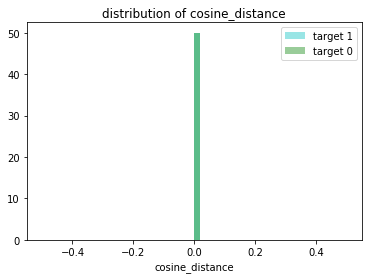

In [23]:
distrib_1 = training[training["target"] == 1]["cosine_distance"]
distrib_0 = training[training["target"] == 0]["cosine_distance"]
print(np.mean(distrib_0))
print(np.mean(distrib_1))
fig, ax = plt.subplots()
sns.distplot(distrib_1, ax=ax, color='c', label="target 1")
sns.distplot(distrib_0, ax=ax, color='g', label="target 0")
ax.set_title("distribution of cosine_distance")
ax.legend()
distrib_1.describe()

In [ ]:
def most_important_words(f, n):
    dic = dict(f)
    ans = {}
    
    for k, v in dic.items():
        ans.update({dictionary.id2token[k]: v})
    
    while len(ans) > n:
        current = 0
        my_min = 2
        for k, v in ans.items():
            if v < my_min:
                my_min = v
                current = k
        del ans[k]
        
    return ans

In [ ]:
id1 = 9510123  # those are two articles that cite each other
id2 = 9502114
print(nodes.at[id1, "abstract"])
print("")
print(nodes.at[id2, "abstract"])
print(cosine_distance(id1, id2))
f1 = get_tf_idf_encoding(id1)
print(most)
most_important_words(f1, 10)